In [1]:
import pandas as pd
import h2o
pd.options.display.max_columns = None
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = r"E:\BP Trabajo\DesercionF\Data\MDTs"

In [4]:
df = pd.read_csv(path+'/MDTSep.txt',sep="\t",dtype={'CodigoCif':str},encoding='latin-1')

In [5]:
df.rename(columns={'Pasivos_Mes3':'Pasivos_Mes2'},inplace=True)

In [6]:
df = df[df.Segmento_N_2.isin(['PERSONAL BAJO', 'PERSONAL', 'PERSONAL PLUS',
       'PREFERENTE', 'PREFERENTE PLUS', 'BANCA PRIVADA'])]

In [7]:
df.CodigoCif.duplicated().sum()

24470

In [8]:
df.drop_duplicates(keep='first',inplace=True)

In [9]:
df.CodigoCif.duplicated().sum()

24470

In [10]:
df.sort_values(['CupoTDCPichincha'],ascending=False,inplace=True)

In [11]:
df.drop_duplicates(['CodigoCif'],keep='first',inplace=True)

In [14]:
df.SituacionLaboral.fillna('NO DEFINIDO',inplace=True)
df.Genero.fillna('NO DEFINIDO',inplace=True)
df.Pasivos_Mes0.fillna(0,inplace=True)
df.Pasivos_Mes1.fillna(0,inplace=True)
df.Pasivos_Mes2.fillna(0,inplace=True)
df.SaldoAh.fillna(0,inplace=True)
df.SaldoAhFuturo.fillna(0,inplace=True)
df.SaldoCte.fillna(0,inplace=True)
df.SaldoPl.fillna(0,inplace=True)
df.Activos_Mes0.fillna(0,inplace=True)
df.Activos_Mes1.fillna(0,inplace=True)
df.Activos_Mes2.fillna(0,inplace=True)
df.CarteraVcdoNoDevenga.fillna(0,inplace=True)
df.NumeroTDCCompetencia.fillna(0,inplace=True)
df.NumeroCreditosCompetencia.fillna(0,inplace=True)
# df.RangoAntiguedad.fillna('Otros',inplace=True)
df.Sow.fillna(0,inplace=True)
# df.ScoreBuro.fillna(0,inplace=True)
df.CarteraSF.fillna(0,inplace=True)
# df.IngresoFinal.fillna(0,inplace=True)
df.CupoTDCCompetencia.fillna(0,inplace=True)
df.CupoTDCPichincha.fillna(0,inplace=True)
df.MontoInicialMaxCompetencia.fillna(0,inplace=True)
df.ClienteBancoCompetencia.fillna(0,inplace=True)
df.ClienteCooperativaCompetencia.fillna(0,inplace=True)

In [15]:
Ingresos = df.groupby(['Segmento_N_2']).agg({'IngresoFinal':np.mean}).reset_index()

In [16]:
for i in Ingresos.Segmento_N_2.unique():
    df.loc[(df.Segmento_N_2==i)&(df.IngresoFinal.isna()),'IngresoFinal'] = Ingresos[Ingresos.Segmento_N_2==i].IngresoFinal.mean()

In [17]:
df.FechaCorte.replace(' 00:00:00.000','',inplace=True)
df.FechaAlta = pd.to_datetime(df.FechaAlta, format="%Y-%m-%d")
df.FechaCorte = pd.to_datetime(df.FechaCorte, format="%Y-%m-%d")
df['Antiguedad'] = (df.FechaCorte - df.FechaAlta).astype('timedelta64[M]')
bins = [-1, 12, 24, 60, 120, 240, np.inf]
names = ['Menor a 1', 'De 1 a 2', 'De 2 a 5', 'De 5 a 10', 'De 10 a 20', 'Mayor a 20']
df['RangoAntiguedad'] = pd.cut(df['Antiguedad'], bins, labels=names)

In [18]:
df.NivelEstudios.fillna('NO DEFINIDO', inplace=True)
df.EstadoCivil.fillna('NO DEFINIDO', inplace=True)

In [19]:
bins = [-np.inf, 25, 39, 51, 71, np.inf]
names = ['Centennials', 'Milennials', 'Generación X', 'Baby Boomers', 'Generación Silenciosa']
df['RangoEtario'] = pd.cut(df.Edad, bins, labels=names)

In [20]:
df['TotalTrx'] = 0
for i in range(42,75):
    df[df.columns[i]].fillna(0,inplace=True)
    df['TotalTrx']  = df['TotalTrx']+df[df.columns[i]]

In [21]:
# df.loc[df.TotalTrx>0,'TotalTrx_'] = 1
# df.loc[df.TotalTrx==0,'TotalTrx_'] = 0

In [22]:
df.ScoreBuro = df.ScoreBuro.str.strip()
df.loc[df.ScoreBuro=='','ScoreBuro'] = np.nan
x=df[df.ScoreBuro.notna()][['CodigoCif','ScoreBuro']]
x.ScoreBuro = x.ScoreBuro.astype(int)
x['RangoScore'] = pd.qcut(x.ScoreBuro, 4, labels=["Alto riesgo", "Riesgo Moderado", "Bajo riesgo", "Sin riesgo"])
df.drop(['ScoreBuro'],axis=1,inplace=True)
df = pd.merge(df,x,how='left',on='CodigoCif')
del x
df.RangoScore = df.RangoScore.astype(str)
df.loc[df.RangoScore=='nan','RangoScore'] = np.nan
df.RangoScore.fillna("NO DEFINIDO",inplace=True)

In [23]:
df['VarAct0_60'] = round(((df['Activos_Mes0'] - df['Activos_Mes2'])/df['Activos_Mes2'])*100,2)
df['VarAct0_30'] = round(((df['Activos_Mes0'] - df['Activos_Mes1'])/df['Activos_Mes1'])*100,2)
df['VarPas0_60'] = round(((df['Pasivos_Mes0'] - df['Pasivos_Mes2'])/df['Pasivos_Mes2'])*100,2)
df['VarPas0_30'] = round(((df['Pasivos_Mes0'] - df['Pasivos_Mes1'])/df['Pasivos_Mes1'])*100,2)

In [24]:
bins = [-np.inf,-100, -66, -33, -1, 1, 33, 66, 100, np.inf]
names = ['Total negativo','Negativo alto', 'Negativo medio', 'Negativo bajo', 'Sin cambio',
         'Positivo bajo', 'Positivo medio', 'Positivo alto', 'Total positivo']
variaciones = ['VarAct0_60','VarAct0_30','VarPas0_60','VarPas0_30']
for variacion in variaciones:
    df[('Rango_'+variacion)] = pd.cut(df[variacion], bins, labels=names)
rangos = ['Rango_VarAct0_60','Rango_VarAct0_30','Rango_VarPas0_60', 'Rango_VarPas0_30']
for rango in rangos:
    df[rango] = df[rango].cat.add_categories('No aplica')
    df[rango].fillna('No aplica', inplace=True)

In [25]:
#Tiene Preciso (15)
df.TienePreciso.fillna(0, inplace=True)

#Tiene Autoseguro (16)
df.TieneAutoseguro.fillna(0, inplace=True)

#Tiene Linea Abierta (17)
df.TieneLineaAbierta.fillna(0, inplace=True)

#Tiene Habitar (18)
df.TieneHabitar.fillna(0, inplace=True)

#Tiene Productivo (19)
df.TieneProductivo.fillna(0, inplace=True)

#Tiene Microempresa (20)
df.TieneMicroempresa.fillna(0, inplace=True)

In [26]:
#Es Rolero (28)
df.Rolero.fillna(0, inplace=True)

#Cuenta de Ahorros (29)
df.TieneCuentaAhorros.fillna(0, inplace=True)

#Plan de Ahorros (30)
df.TienePlanAhorros.fillna(0, inplace=True)

#Inversiones (31)
df.TieneInversiones.fillna(0, inplace=True)

#CuentaCorriente (31)
df.TieneCuentaCorriente.fillna(0, inplace=True)

In [27]:
bins = [-np.inf, 0, 1, 2, 3, 4, np.inf]
names = ['Sin cargas','Una carga', 'Dos cargas', 'Tres cargas', 'Cuatro cargas', 'Mas de cuatro cargas']
df['CargasFamiliares'] = pd.cut(df.NumeroCargasFamiliares, bins, labels=names)

In [28]:
df.TieneEducativo.fillna(0, inplace=True)

df.TieneCarteraTarjeta.fillna(0, inplace=True)

df.TieneSobregiros.fillna(0, inplace=True)

df.TieneCarteraComprada.fillna(0, inplace=True)

In [29]:
columnas_drop = []
for i in df.columns:
    if df[i].isna().sum() > 0:
        print(i)
        columnas_drop.append(i)

CondicionFinal_2f
ScoreBuro
VarAct0_60
VarAct0_30
VarPas0_60
VarPas0_30


In [30]:
col = ['CodigoCif', 'Segmento_N_2', 'SituacionLaboral', 'NivelEstudios',
       'EstadoCivil', 'Genero', 'Ivc', 'Rolero',
       'IngresoFinal',  'TienePreciso',
       'TieneCarteraComprada', 'TieneAutoseguro', 'TieneLineaAbierta',
       'TieneSobregiros', 'TieneHabitar', 'TieneProductivo',
       'TieneCarteraTarjeta', 'TieneMicroempresa', 'TieneEducativo',
       'TieneCuentaAhorros', 'TienePlanAhorros', 'TieneCuentaCorriente',
       'TieneInversiones','Sow',
       'NumeroTDCCompetencia', 'CupoTDCCompetencia', 'CupoTDCPichincha',
       'NumeroCreditosCompetencia', 'MontoInicialMaxCompetencia',
       'ClienteBancoCompetencia', 'ClienteCooperativaCompetencia',
       'CondicionFinal_0', 'RangoAntiguedad', 'RangoEtario', 'TotalTrx', 'RangoScore',
       'Rango_VarAct0_60', 'Rango_VarAct0_30', 'Rango_VarPas0_60',
       'Rango_VarPas0_30', 'CargasFamiliares']

In [31]:
df = df[col]

In [32]:
tenencia = ['TienePreciso', 'TieneCarteraComprada', 'TieneAutoseguro',
       'TieneLineaAbierta', 'TieneSobregiros', 'TieneHabitar',
       'TieneProductivo', 'TieneCarteraTarjeta', 'TieneMicroempresa',
       'TieneEducativo','Rolero','TieneCuentaAhorros', 'TienePlanAhorros',
       'TieneCuentaCorriente', 'TieneInversiones','ClienteBancoCompetencia','ClienteCooperativaCompetencia']
for i in tenencia:
    df[i] = df[i].astype('category')

In [33]:
df.select_dtypes(float).columns

Index(['IngresoFinal', 'Sow', 'NumeroTDCCompetencia', 'CupoTDCCompetencia',
       'CupoTDCPichincha', 'NumeroCreditosCompetencia',
       'MontoInicialMaxCompetencia', 'TotalTrx'],
      dtype='object')

In [34]:
from scipy.stats import iqr

In [35]:
df.loc[df.NumeroTDCCompetencia>df.NumeroTDCCompetencia.quantile(0.99),'NumeroTDCCompetencia'] = df.NumeroTDCCompetencia.quantile(0.99)
df.loc[df.CupoTDCPichincha>df.CupoTDCPichincha.quantile(0.99),'CupoTDCCompetencia'] = df.CupoTDCPichincha.quantile(0.99)
df.loc[df.NumeroCreditosCompetencia>df.NumeroCreditosCompetencia.quantile(0.9999),'NumeroCreditosCompetencia'] = df.NumeroCreditosCompetencia.quantile(0.9999)
df.loc[df.MontoInicialMaxCompetencia>df.MontoInicialMaxCompetencia.quantile(0.99),'MontoInicialMaxCompetencia'] = df.MontoInicialMaxCompetencia.quantile(0.99)
df.loc[df.CupoTDCCompetencia>df.CupoTDCCompetencia.quantile(0.99),'CupoTDCCompetencia'] = df.CupoTDCCompetencia.quantile(0.99)

In [36]:
df.describe()

,Ivc,IngresoFinal,Sow,NumeroTDCCompetencia,CupoTDCCompetencia,CupoTDCPichincha,NumeroCreditosCompetencia,MontoInicialMaxCompetencia,TotalTrx
count,3.165563e+06,3.165563e+06,3.165563e+06,3.165563e+06,3.165563e+06,3.165563e+06,3.165563e+06,3.165563e+06,3.165563e+06
mean,1.820730e+00,9.371107e+02,1.284670e-01,4.318973e-01,1.449995e+03,5.297820e+02,2.863791e-01,2.271638e+03,7.952901e+01
std,9.837916e-01,9.536864e+02,3.045784e-01,9.516275e-01,4.011552e+03,2.084846e+03,6.632951e-01,6.399349e+03,1.476900e+02
min,0.000000e+00,1.330000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,3.981300e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,2.000000e+00,5.906600e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01
75%,2.000000e+00,1.034290e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.700000e+01
max,1.100000e+01,1.825295e+05,1.000000e+00,5.000000e+00,2.510000e+04,7.500000e+04,8.000000e+00,3.900000e+04,1.650000e+04


## Correlaciones

In [37]:
for i in df.select_dtypes(float).columns:
    for j in df.select_dtypes(float).columns:
        if (df[i].corr(df[j]) > 0.6) & (i != j):
            print(i,j,df[i].corr(df[j]))

NumeroTDCCompetencia CupoTDCCompetencia 0.752829083552422
CupoTDCCompetencia NumeroTDCCompetencia 0.752829083552422
NumeroCreditosCompetencia MontoInicialMaxCompetencia 0.720472668343524
MontoInicialMaxCompetencia NumeroCreditosCompetencia 0.720472668343524


In [38]:
df.drop(['CupoTDCCompetencia','MontoInicialMaxCompetencia'],axis=1,inplace=True)

In [39]:
corr = df.corr()

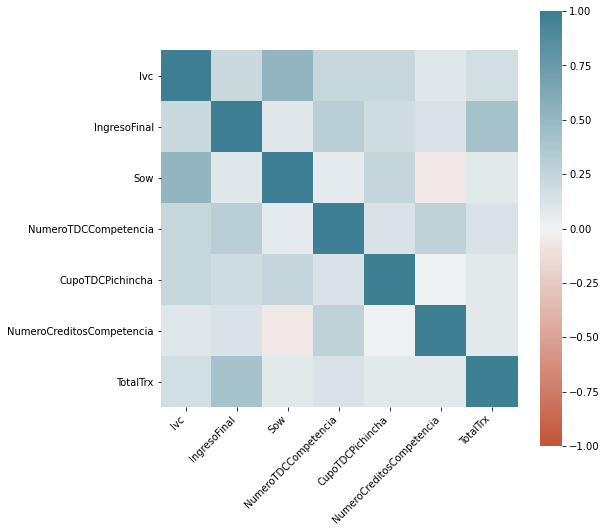

In [40]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Creacion Modelo 
Condicion 

In [41]:
df.CondicionFinal_0.unique()

array(['ACTIVO', 'INACTIVO', 'REACTIVO', 'REINACTIVO', 'NUEVO',
       'FALLECIDO'], dtype=object)

In [42]:
df['Clase'] = np.where((df['CondicionFinal_0'].isin(['INACTIVO', 'REINACTIVO'])),1,0)

In [43]:
df.set_index('CodigoCif', inplace=True)
df = df[(~df.CondicionFinal_0.isin(['NUEVO','FALLECIDO']))]

In [44]:
df.drop(['CondicionFinal_0'],axis=1,inplace=True)

In [45]:
# df.to_csv(path+'/DataLimpia.csv',index=False)

In [46]:
df['Trx0_60'] = np.where(df['TotalTrx']>0,1,0)

In [47]:
df['Trx0_60'] = df['Trx0_60'].astype('category')

In [48]:
df = df.reset_index()

## H2O

In [49]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.301-b09, mixed mode)
  Starting server from C:\Users\alexm\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\alexm\AppData\Local\Temp\tmp5_xrx0kj
  JVM stdout: C:\Users\alexm\AppData\Local\Temp\tmp5_xrx0kj\h2o_alexm_started_from_python.out
  JVM stderr: C:\Users\alexm\AppData\Local\Temp\tmp5_xrx0kj\h2o_alexm_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.3
H2O_cluster_version_age:,11 months and 25 days !!!
H2O_cluster_name:,H2O_from_python_alexm_wve28j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.523 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


In [50]:
h2o.remove_all()

In [51]:
df.shape

(3119304, 40)

In [52]:
df.columns

Index(['CodigoCif', 'Segmento_N_2', 'SituacionLaboral', 'NivelEstudios',
       'EstadoCivil', 'Genero', 'Ivc', 'Rolero', 'IngresoFinal',
       'TienePreciso', 'TieneCarteraComprada', 'TieneAutoseguro',
       'TieneLineaAbierta', 'TieneSobregiros', 'TieneHabitar',
       'TieneProductivo', 'TieneCarteraTarjeta', 'TieneMicroempresa',
       'TieneEducativo', 'TieneCuentaAhorros', 'TienePlanAhorros',
       'TieneCuentaCorriente', 'TieneInversiones', 'Sow',
       'NumeroTDCCompetencia', 'CupoTDCPichincha', 'NumeroCreditosCompetencia',
       'ClienteBancoCompetencia', 'ClienteCooperativaCompetencia',
       'RangoAntiguedad', 'RangoEtario', 'TotalTrx', 'RangoScore',
       'Rango_VarAct0_60', 'Rango_VarAct0_30', 'Rango_VarPas0_60',
       'Rango_VarPas0_30', 'CargasFamiliares', 'Clase', 'Trx0_60'],
      dtype='object')

In [53]:
# x = df.sample(100000)
x = df.copy()

In [54]:
data = h2o.H2OFrame(x)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [55]:
data['Clase'] = data['Clase'].asfactor()
data['Clase'].levels()

[['0', '1']]

In [56]:
clases = data["Clase"].table()
print(clases)

Clase,Count
0,2.67893e+06
1,440371


<AxesSubplot:xlabel='Clase'>

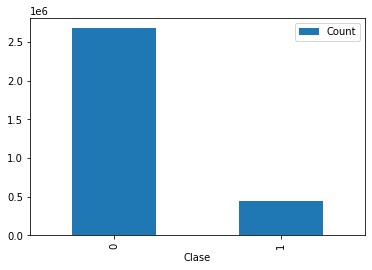

In [57]:
clases = clases.as_data_frame(use_pandas = True, header=True)
clases.plot.bar(x="Clase", y= "Count")

In [58]:
for i in tenencia:
    data[i] = data[i].asfactor()

In [59]:
splits = data.split_frame(ratios=[0.9, 0.05], seed=1953)  

train = splits[0]
valid = splits[1]
test = splits[2]

print('El set de entramiento tiene ' + str(train.nrow)+ ' filas.')
print('El set de validacion tiene ' +str(valid.nrow)+ ' filas.') 
print('El set de testeo tiene ' +str(test.nrow)+ ' filas.')

El set de entramiento tiene 2807250 filas.
El set de validacion tiene 155994 filas.
El set de testeo tiene 156061 filas.


In [60]:
y = 'Clase'

In [61]:
x = ['Segmento_N_2', 'SituacionLaboral', 'NivelEstudios', 'EstadoCivil',
       'Genero', 'Ivc', 'Rolero', 'IngresoFinal', 'TienePreciso',
       'TieneCarteraComprada', 'TieneAutoseguro', 'TieneLineaAbierta',
       'TieneSobregiros', 'TieneHabitar', 'TieneProductivo',
       'TieneCarteraTarjeta', 'TieneMicroempresa', 'TieneEducativo',
       'TieneCuentaAhorros', 'TienePlanAhorros', 'TieneCuentaCorriente',
       'TieneInversiones', 'Sow', 'NumeroTDCCompetencia', 'CupoTDCPichincha',
       'NumeroCreditosCompetencia', 'ClienteBancoCompetencia',
       'ClienteCooperativaCompetencia', 'RangoAntiguedad', 'RangoEtario',
       'Trx0_60', 'RangoScore', 'Rango_VarAct0_60', 'Rango_VarAct0_30',
       'Rango_VarPas0_60', 'Rango_VarPas0_30', 'CargasFamiliares']

In [62]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [63]:
gbm_fit1 = H2OGradientBoostingEstimator(
                      distribution = "bernoulli",     # Tipo de distribución (clasificación binaria)
                      categorical_encoding = 'Enum',  # Codificacion de variables categoricas (OneHotExplicit/Enum)
                      ntrees = 100,                   # Numero de arboles
                      max_depth = 10,                 # Complejidad de los árboles
                      learn_rate = 0.1,               # Tasa de aprendizaje
                      sample_rate = 0.8,              # Tasa de muestreo
                      nfolds = 5,                     # Numero de folds para validacion cruzada    
                      score_tree_interval = 5,        # Parametros de detención temprana y stop
                      stopping_rounds = 3,
                      stopping_metric = "AUC",
                      stopping_tolerance = 0.001,
                      model_id = "Churn_V2",          # Identificador del modelo
                      seed = 1953)                    # Seed del proceso

In [64]:
gbm_fit1.train(
    # Variable respuesta y predictores.
    y = y,
    x = x,
    # Datos de entrenamiento.
    training_frame = train,
    # Datos de validación para estimar el error.
    validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [65]:
# Área bajo la curva
print("auc: ", gbm_fit1.auc(valid=True))
# Mean Squared Error
print("Mean Squared Error: ",gbm_fit1.mse(valid=True))
# R2
print("R2: ",gbm_fit1.r2(valid=True))
# LogLoss
print("LogLoss: ",gbm_fit1.logloss(valid=True))
# Coeficiente de Gini
print("Gini: ",gbm_fit1.gini(valid=True))
# Accuracy
print("Accuracy: ",gbm_fit1.accuracy(valid=True))

auc:  0.9871022554199974
Mean Squared Error:  0.029655883671552228
R2:  0.7560110109796618
LogLoss:  0.10325142627194368
Gini:  0.9742045108399948
Accuracy:  [[0.4876781053532918, 0.9599664089644474]]


In [66]:
gbm_fit1.confusion_matrix(thresholds=0.42)

Could not find exact threshold 0.42; using closest threshold found 0.419223434595928.

Confusion Matrix (Act/Pred) @ threshold = 0.419223434595928: 


,,0,1,Error,Rate
0,0,2343469.0,67462.0,0.028,(67462.0/2410931.0)
1,1,44710.0,351609.0,0.1128,(44710.0/396319.0)
2,Total,2388179.0,419071.0,0.04,(112172.0/2807250.0)


In [67]:
# H2O almacena las métricas de entrenamiento y test bajo el nombre de scoring.
# Los valores se encuentran almacenados dentro del modelo.
historial_scoring = gbm_fit1.scoring_history()
historial_scoring.head(20)

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-12-20 10:10:11,6 min 36.840 sec,0.0,0.348204,0.407094,0.500000,0.141177,1.000000,0.858823,0.348635,0.407849,0.500000,0.141595,1.000000,0.858405
1,,2021-12-20 10:10:18,6 min 44.597 sec,5.0,0.244954,0.221035,0.986278,0.923202,7.083309,0.041125,0.245302,0.221667,0.985793,0.923168,7.062387,0.040918
2,,2021-12-20 10:10:26,6 min 52.245 sec,10.0,0.201671,0.160989,0.986565,0.924779,7.083309,0.041002,0.202228,0.161895,0.986058,0.924327,7.062387,0.040828
3,,2021-12-20 10:10:34,7 min 0.594 sec,15.0,0.183543,0.131563,0.986937,0.926399,7.083309,0.040872,0.184342,0.132724,0.986501,0.925991,7.062387,0.041412
4,,2021-12-20 10:10:43,7 min 8.781 sec,20.0,0.176072,0.115755,0.987140,0.928027,7.083309,0.040678,0.177096,0.117137,0.986677,0.927511,7.062387,0.041021
5,,2021-12-20 10:10:52,7 min 17.690 sec,25.0,0.172536,0.106653,0.987401,0.929602,7.077003,0.040513,0.173817,0.108304,0.986897,0.929043,7.062387,0.040796
6,,2021-12-20 10:11:03,7 min 29.564 sec,30.0,0.170641,0.101282,0.987660,0.930805,7.076749,0.040093,0.172209,0.103251,0.987102,0.930011,7.062387,0.041040


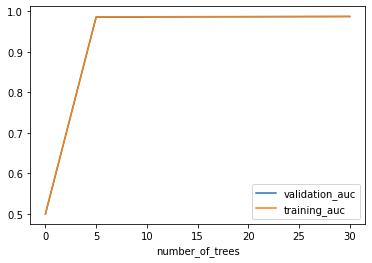

In [68]:
plot = historial_scoring.plot(x="number_of_trees",
                              y=["validation_auc","training_auc"],
                              kind='line')

In [69]:
gbm_fit1.varimp(use_pandas=True).head(38)

,variable,relative_importance,scaled_importance,percentage
0,Trx0_60,1.005303e+06,1.000000e+00,8.081514e-01
1,Rango_VarPas0_60,7.467414e+04,7.428021e-02,6.002966e-02
2,Rango_VarAct0_30,4.629237e+04,4.604816e-02,3.721389e-02
3,IngresoFinal,4.242488e+04,4.220107e-02,3.410486e-02
4,Rango_VarPas0_30,2.435514e+04,2.422666e-02,1.957881e-02
5,Rango_VarAct0_60,1.490444e+04,1.482581e-02,1.198150e-02
6,TieneInversiones,7.320733e+03,7.282114e-03,5.885051e-03
7,RangoEtario,5.544554e+03,5.515305e-03,4.457201e-03
8,RangoScore,3.074382e+03,3.058163e-03,2.471459e-03
9,SituacionLaboral,2.665978e+03,2.651914e-03,2.143148e-03


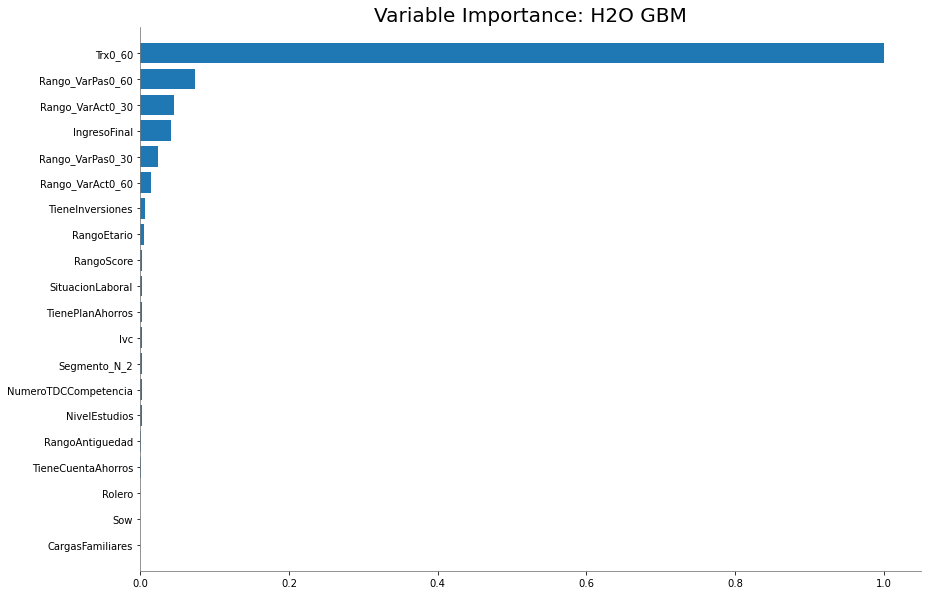

In [70]:
gbm_fit1.varimp_plot(num_of_features=20)

In [261]:
# contributions = gbm_fit1.predict_contributions(test)

contributions progress: |█████████████████████████████████████████████████| 100%


In [262]:
contributions

Segmento_N_2,SituacionLaboral,NivelEstudios,EstadoCivil,Genero,Ivc,Rolero,IngresoFinal,TienePreciso,TieneCarteraComprada,TieneAutoseguro,TieneLineaAbierta,TieneSobregiros,TieneHabitar,TieneProductivo,TieneCarteraTarjeta,TieneMicroempresa,TieneEducativo,TieneCuentaAhorros,TienePlanAhorros,TieneCuentaCorriente,TieneInversiones,Sow,NumeroTDCCompetencia,CupoTDCPichincha,NumeroCreditosCompetencia,ClienteBancoCompetencia,ClienteCooperativaCompetencia,RangoAntiguedad,RangoEtario,RangoScore,Rango_VarAct0_60,Rango_VarAct0_30,Rango_VarPas0_60,Rango_VarPas0_30,CargasFamiliares,Trx0_60,BiasTerm
-0.00460963,0.00451682,-0.0333291,-0.00125595,0.00331793,-0.00587385,0.00540701,-0.0387807,-5.92909e-08,1.74805e-09,-1.68257e-11,0,0,3.37013e-08,0,7.23544e-05,0,0,-0.00266022,0.00449809,0.000138169,0.00214424,0.00135944,-0.00347249,0.00178101,-0.0031162,-0.000223758,-9.93142e-05,-0.0108672,0.00405354,0.000304652,0.0742551,0.0518317,-0.554038,-0.342078,8.30906e-05,-0.817667,-3.22743
-0.00588895,-0.000770817,-0.00092797,-0.00460961,-0.00287388,-0.0138071,0.00569756,-0.124328,-5.91276e-08,1.27511e-09,-1.68257e-11,0,0,3.28541e-08,0,7.188e-05,0,0,-0.00259323,0.0133067,0.000354404,0.00142692,0.000913837,-0.002372,0.00266761,-0.00270182,-0.000112427,-4.79355e-05,0.0221166,-0.0114413,0.000191342,0.0612409,0.0516393,-0.685835,-0.270737,-0.00134001,-0.690666,-3.22743
0.00916463,-0.0669988,0.00370369,0.0146015,-0.0132163,-0.0094934,0.00541599,-0.443388,-7.35681e-08,1.78261e-09,-7.27596e-12,0,0,3.7548e-08,0,7.24295e-05,0,0,-0.00373316,-0.00969019,-0.000383987,0.00165839,-0.00415676,-0.00610815,0.000688612,-0.00678027,-0.00084464,-0.000674003,-0.00669417,0.0655273,0.0133451,0.0548204,0.0927852,-0.721241,0.50416,-0.0522141,-0.473029,-3.22743
-0.0142948,0.00115954,-0.00606708,-0.00505702,-0.000608972,-0.0128414,0.0045939,-0.0295587,-5.91276e-08,1.27511e-09,-4.09273e-12,0,0,3.419e-08,0,0.000118675,0,0,-0.00232896,0.00468379,0.000245207,0.00208822,0.0010862,-0.00429732,0.00268401,0.00086892,0.000718761,-0.0002865,0.0017719,-0.00108165,0.00902604,0.073734,0.0485143,-0.613098,-0.344684,0.000248979,-0.800094,-3.22743
0.00171735,-0.000193884,-0.0535498,-0.00158876,-0.0022461,0.0141549,0.00626463,0.111233,-2.48185e-07,4.5693e-09,5.45697e-12,0,0,6.20903e-08,0,-1.01174e-05,0,0,-0.00308576,0.0118803,0.000195041,0.00107313,0.0053007,-0.0011095,-0.0225816,-0.00229025,-0.000284972,-3.68132e-06,0.0143615,0.0134543,-0.0158075,-0.318328,-0.265738,-0.597824,-0.134133,-0.0121272,-0.374531,-3.22743
0.0312752,-0.0934725,0.00489213,0.0282265,-0.00805348,0.044977,0.00401476,0.0152594,-4.86143e-08,5.78439e-09,7.09406e-11,0,0,5.21775e-08,0,5.44132e-05,0,0,-0.00870333,0.0332284,0.00146091,0.0207543,0.000279508,-0.00909614,-0.0599653,-0.0300865,-0.00154883,0.000368918,-0.0545172,-0.144755,-0.0322951,0.362329,0.207411,0.724803,0.100137,0.00982121,2.74847,-3.22743
0.000537147,0.00285376,-0.0277011,0.00289154,0.00172579,-0.00233091,0.00378063,0.00467886,1.01652e-07,4.60204e-09,9.09495e-12,0,0,5.8606e-08,0,0.000196674,0,0,-0.0017007,0.00190437,0.000228462,0.00106178,-0.0043094,0.000255758,-0.0201756,0.00584111,0.00222853,-0.000195761,-0.00794644,0.00644164,-0.0225355,-0.325038,-0.24359,-0.623525,-0.121105,-0.00450291,-0.395647,-3.22743
-0.00675551,0.0101702,-0.0371773,-0.015262,0.00408787,-0.00182625,0.00582658,-0.212661,-7.24012e-08,1.77079e-09,-1.36424e-11,0,0,4.3575e-08,0,0.000538305,0,0,-0.00254407,0.00268785,-0.000348195,0.00153466,0.00129026,0.0657168,0.0015668,0.0130095,0.00130587,-0.000277064,-0.0135812,0.0082482,0.00273707,0.073614,0.0548733,-0.5429,-0.246435,-0.00178691,-0.914227,-3.22743
0.012988,0.0203982,0.0185924,-0.00671558,0.00997777,0.0106076,0.00431888,0.120547,-2.12429e-07,3.71074e-09,6.73026e-11,0,0,1.88184e-07,0,0.000187278,0,0,-0.00156253,-0.00309333,0.00083431,0.00681799,0.00334423,-0.00246893,-0.000710089,-0.00222953,-0.00047003,0.00123778,0.0266652,0.0074893,-0.000504019,0.525633,0.351656,0.401935,0.96143,0.00141173,3.99121,-3.22743
-0.000633133,-0.0045717,-0.010951,-

In [263]:
predict_contributions = test[['CodigoCif']].cbind(contributions)

In [264]:
predict_contributions = h2o.as_list(predict_contributions, use_pandas=True)

In [265]:
temp = pd.melt(predict_contributions,id_vars=['CodigoCif'])

In [266]:
temp['value'] = temp.value.abs()

In [267]:
remove = ['BiasTerm','p1']
temp = temp[~temp['variable'].isin(remove)]

In [268]:
temp = temp.sort_values(by=['CodigoCif','value'],ascending=False)

In [269]:
temp['rank'] = temp.groupby('CodigoCif')['value'].rank(ascending=False, method='first')

In [270]:
a = pd.pivot_table(temp[['CodigoCif','variable','rank']],values='variable',index=['CodigoCif'],columns='rank',aggfunc=lambda x: ' '.join(x)).reset_index()

In [271]:
a.head()

rank,CodigoCif,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0
0,5604,Trx0_60,Rango_VarPas0_30,Rango_VarAct0_60,Rango_VarPas0_60,Rango_VarAct0_30,RangoScore,RangoEtario,RangoAntiguedad,Segmento_N_2,SituacionLaboral,EstadoCivil,IngresoFinal,TienePlanAhorros,CargasFamiliares,TieneInversiones,ClienteBancoCompetencia,Rolero,NumeroCreditosCompetencia,Genero,NivelEstudios,Sow,ClienteCooperativaCompetencia,NumeroTDCCompetencia,TieneCuentaCorriente,TieneCarteraTarjeta,TieneCuentaAhorros,Ivc,CupoTDCPichincha,TieneHabitar,TienePreciso,TieneCarteraComprada,TieneAutoseguro,TieneLineaAbierta,TieneSobregiros,TieneProductivo,TieneMicroempresa,TieneEducativo
1,9091,Rango_VarPas0_60,Trx0_60,Rango_VarAct0_60,Rango_VarAct0_30,Rango_VarPas0_30,IngresoFinal,NumeroTDCCompetencia,RangoEtario,RangoAntiguedad,NivelEstudios,RangoScore,Segmento_N_2,Ivc,SituacionLaboral,NumeroCreditosCompetencia,CargasFamiliares,TienePlanAhorros,Rolero,TieneCuentaCorriente,CupoTDCPichincha,TieneCuentaAhorros,Sow,TieneInversiones,Genero,EstadoCivil,ClienteBancoCompetencia,ClienteCooperativaCompetencia,TieneCarteraTarjeta,TieneHabitar,TienePreciso,TieneCarteraComprada,TieneAutoseguro,TieneLineaAbierta,TieneSobregiros,TieneProductivo,TieneMicroempresa,TieneEducativo
2,12633,Rango_VarPas0_60,Trx0_60,Rango_VarAct0_60,Rango_VarAct0_30,Rango_VarPas0_30,IngresoFinal,RangoAntiguedad,RangoEtario,TieneCuentaAhorros,RangoScore,TieneCuentaCorriente,NivelEstudios,CargasFamiliares,EstadoCivil,TienePlanAhorros,ClienteBancoCompetencia,NumeroCreditosCompetencia,NumeroTDCCompetencia,CupoTDCPichincha,Rolero,Sow,Segmento_N_2,Ivc,SituacionLaboral,TieneInversiones,Genero,ClienteCooperativaCompetencia,TieneCarteraTarjeta,TieneHabitar,TienePreciso,TieneCarteraComprada,TieneAutoseguro,TieneLineaAbierta,TieneSobregiros,TieneProductivo,TieneMicroempresa,TieneEducativo
3,15728,Rango_VarPas0_60,Rango_VarAct0_60,Rango_VarAct0_30,Trx0_60,IngresoFinal,Rango_VarPas0_30,Ivc,RangoAntiguedad,SituacionLaboral,Sow,RangoScore,TienePlanAhorros,RangoEtario,TieneCuentaCorriente,NivelEstudios,Genero,CargasFamiliares,Segmento_N_2,ClienteBancoCompetencia,TieneCuentaAhorros,Rolero,NumeroCreditosCompetencia,CupoTDCPichincha,EstadoCivil,NumeroTDCCompetencia,TieneInversiones,ClienteCooperativaCompetencia,TieneCarteraTarjeta,TieneHabitar,TienePreciso,TieneCarteraComprada,TieneAutoseguro,TieneLineaAbierta,TieneSobregiros,TieneProductivo,TieneMicroempresa,TieneEducativo
4,16944,Rango_VarPas0_60,Trx0_60,Rango_VarAct0_60,Rango_VarAct0_30,Rango_VarPas0_30,IngresoFinal,Sow,RangoEtario,RangoAntiguedad,NivelEstudios,TienePlanAhorros,Segmento_N_2,SituacionLaboral,NumeroTDCCompetencia,RangoScore,Ivc,Rolero,EstadoCivil,NumeroCreditosCompetencia,CupoTDCPichincha,TieneCuentaAhorros,Genero,TieneInversiones,TieneCarteraTarjeta,ClienteBancoCompetencia,CargasFamiliares,ClienteCooperativaCompetencia,TieneCuentaCorriente,TieneHabitar,TienePreciso,TieneCarteraComprada,TieneAutoseguro,TieneLineaAbierta,TieneSobregiros,TieneProductivo,TieneMicroempresa,TieneEducativo


In [275]:
a.CodigoCif = a.CodigoCif.astype(str).str.zfill(14)

In [276]:
a.head()

rank,CodigoCif,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0
0,00000000005604,Trx0_60,Rango_VarPas0_30,Rango_VarAct0_60,Rango_VarPas0_60,Rango_VarAct0_30,RangoScore,RangoEtario,RangoAntiguedad,Segmento_N_2,SituacionLaboral,EstadoCivil,IngresoFinal,TienePlanAhorros,CargasFamiliares,TieneInversiones,ClienteBancoCompetencia,Rolero,NumeroCreditosCompetencia,Genero,NivelEstudios,Sow,ClienteCooperativaCompetencia,NumeroTDCCompetencia,TieneCuentaCorriente,TieneCarteraTarjeta,TieneCuentaAhorros,Ivc,CupoTDCPichincha,TieneHabitar,TienePreciso,TieneCarteraComprada,TieneAutoseguro,TieneLineaAbierta,TieneSobregiros,TieneProductivo,TieneMicroempresa,TieneEducativo
1,00000000009091,Rango_VarPas0_60,Trx0_60,Rango_VarAct0_60,Rango_VarAct0_30,Rango_VarPas0_30,IngresoFinal,NumeroTDCCompetencia,RangoEtario,RangoAntiguedad,NivelEstudios,RangoScore,Segmento_N_2,Ivc,SituacionLaboral,NumeroCreditosCompetencia,CargasFamiliares,TienePlanAhorros,Rolero,TieneCuentaCorriente,CupoTDCPichincha,TieneCuentaAhorros,Sow,TieneInversiones,Genero,EstadoCivil,ClienteBancoCompetencia,ClienteCooperativaCompetencia,TieneCarteraTarjeta,TieneHabitar,TienePreciso,TieneCarteraComprada,TieneAutoseguro,TieneLineaAbierta,TieneSobregiros,TieneProductivo,TieneMicroempresa,TieneEducativo
2,00000000012633,Rango_VarPas0_60,Trx0_60,Rango_VarAct0_60,Rango_VarAct0_30,Rango_VarPas0_30,IngresoFinal,RangoAntiguedad,RangoEtario,TieneCuentaAhorros,RangoScore,TieneCuentaCorriente,NivelEstudios,CargasFamiliares,EstadoCivil,TienePlanAhorros,ClienteBancoCompetencia,NumeroCreditosCompetencia,NumeroTDCCompetencia,CupoTDCPichincha,Rolero,Sow,Segmento_N_2,Ivc,SituacionLaboral,TieneInversiones,Genero,ClienteCooperativaCompetencia,TieneCarteraTarjeta,TieneHabitar,TienePreciso,TieneCarteraComprada,TieneAutoseguro,TieneLineaAbierta,TieneSobregiros,TieneProductivo,TieneMicroempresa,TieneEducativo
3,00000000015728,Rango_VarPas0_60,Rango_VarAct0_60,Rango_VarAct0_30,Trx0_60,IngresoFinal,Rango_VarPas0_30,Ivc,RangoAntiguedad,SituacionLaboral,Sow,RangoScore,TienePlanAhorros,RangoEtario,TieneCuentaCorriente,NivelEstudios,Genero,CargasFamiliares,Segmento_N_2,ClienteBancoCompetencia,TieneCuentaAhorros,Rolero,NumeroCreditosCompetencia,CupoTDCPichincha,EstadoCivil,NumeroTDCCompetencia,TieneInversiones,ClienteCooperativaCompetencia,TieneCarteraTarjeta,TieneHabitar,TienePreciso,TieneCarteraComprada,TieneAutoseguro,TieneLineaAbierta,TieneSobregiros,TieneProductivo,TieneMicroempresa,TieneEducativo
4,00000000016944,Rango_VarPas0_60,Trx0_60,Rango_VarAct0_60,Rango_VarAct0_30,Rango_VarPas0_30,IngresoFinal,Sow,RangoEtario,RangoAntiguedad,NivelEstudios,TienePlanAhorros,Segmento_N_2,SituacionLaboral,NumeroTDCCompetencia,RangoScore,Ivc,Rolero,EstadoCivil,NumeroCreditosCompetencia,CupoTDCPichincha,TieneCuentaAhorros,Genero,TieneInversiones,TieneCarteraTarjeta,ClienteBancoCompetencia,CargasFamiliares,ClienteCooperativaCompetencia,TieneCuentaCorriente,TieneHabitar,TienePreciso,TieneCarteraComprada,TieneAutoseguro,TieneLineaAbierta,TieneSobregiros,TieneProductivo,TieneMicroempresa,TieneEducativo


In [3]:
nov = pd.read_csv(path+'/MDTNov.txt',sep="\t",dtype={'CodigoCif':str},encoding='latin-1')

In [4]:
nov.head()

,FechaCorte,CodigoCif,FechaAlta,Segmento_N_2,Subsegmento,SituacionLaboral,NivelEstudios,NumeroCargasFamiliares,EstadoCivil,Genero,Edad,Zona,ScoreBuro,CarteraSF,Ivc,Rolero,IngresoFinal,Pasivos_Mes0,Pasivos_Mes1,Pasivos_Mes3,SaldoAh,SaldoAhFuturo,SaldoCte,SaldoPl,Activos_Mes0,Activos_Mes1,Activos_Mes2,CarteraVcdoNoDevenga,TienePreciso,TieneCarteraComprada,TieneAutoseguro,TieneLineaAbierta,TieneSobregiros,TieneHabitar,TieneProductivo,TieneCarteraTarjeta,TieneMicroempresa,TieneEducativo,TieneCuentaAhorros,TienePlanAhorros,TieneCuentaCorriente,TieneInversiones,TrxApp_Mes0,TrxAtm_Mes0,TrxBilleteraMovil_Mes0,TrxCajas_Mes0,TrxCC_Mes0,TrxCnb_Mes0,TrxInternet_Mes0,TrxTdc_Mes0,TrxUssd_Mes0,TrxTdd_Mes0,TrxIvr_Mes0,TrxApp_Mes1,TrxAtm_Mes1,TrxBilleteraMovil_Mes1,TrxCajas_Mes1,TrxCC_Mes1,TrxCnb_Mes1,TrxInternet_Mes1,TrxTdc_Mes1,TrxUssd_Mes1,TrxTdd_Mes1,TrxIvr_Mes1,TrxApp_Mes2,TrxAtm_Mes2,TrxBilleteraMovil_Mes2,TrxCajas_Mes2,TrxCC_Mes2,TrxCnb_Mes2,TrxInternet_Mes2,TrxTdc_Mes2,TrxUssd_Mes2,TrxTdd_Mes2,TrxIvr_Mes2,Sow,NumeroTDCCompetencia,CupoTDCCompetencia,CupoTDCPichincha,NumeroCreditosCompetencia,MontoInicialMaxCompetencia,ClienteBancoCompetencia,ClienteCooperativaCompetencia,CondicionFinal_0
0,2021-09-30 00:00:00.000,0000000006149903,2013-05-22 00:00:00.000,PERSONAL BAJO,CONSUMO,EMPLEADO,MEDIOS / SECUNDARIOS,1,SOLTERO,MASCULINO,33,ZONA COSTA 7 MANABI,NaN,NaN,2,NaN,965.76,107.69,10.45,0.66,0.45,10.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1.0,1.0,NaN,NaN,102.0,8,0,1,0,14,NaN,NaN,0,13.0,NaN,141.0,7.0,0.0,2.0,0.0,19.0,NaN,NaN,0.0,9.0,NaN,105.0,6.0,0.0,3.0,0.0,15.0,NaN,NaN,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ACTIVO
1,2021-09-30 00:00:00.000,0000000006475909,2014-02-21 00:00:00.000,PERSONAL BAJO,MASIVO PERSONAL B 2,INDEPENDIENTE,UNIVERSITARIOS,0,SOLTERO,FEMENINO,34,ZONA 2 - CENTRO ORIENTE,NaN,NaN,1,NaN,2309.54,10904.33,11751.59,1723.64,11751.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1.0,NaN,NaN,NaN,38.0,3,5,0,0,0,2.0,NaN,0,NaN,NaN,26.0,3.0,6.0,0.0,0.0,0.0,1.0,NaN,0.0,2.0,NaN,20.0,2.0,9.0,0.0,0.0,0.0,3.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ACTIVO
2,2021-09-30 00:00:00.000,0000000003969696,2008-10-21 00:00:00.000,PERSONAL BAJO,MASIVO PERSONAL B 2,INDEPENDIENTE,MEDIOS / SECUNDARIOS,0,CASADO,MASCULINO,37,ZONA 1 - NORORIENTE,NaN,NaN,1,1.0,481.73,2.45,5.02,44.10,5.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1.0,NaN,NaN,NaN,NaN,2,0,0,0,3,NaN,NaN,0,NaN,NaN,NaN,5.0,0.0,0.0,0.0,5.0,NaN,NaN,0.0,NaN,NaN,NaN,4.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ACTIVO
3,2021-09-30 00:00:00.000,0000000002843451,2004-12-28 00:00:00.000,PERSONAL,MASIVO PERSONAL B,NO TRABAJA,UNIVERSITARIOS,2,CASADO,FEMENINO,37,ZONA SIERRA NORTE,913,NaN,1,NaN,881.43,3265.82,3299.56,2757.70,3299.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1.0,NaN,NaN,NaN,27.0,2,0,0,0,0,NaN,NaN,0,NaN,NaN,29.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,NaN,NaN,35.0,3.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1000.0,NaN,NaN,NaN,1.0,NaN,ACTIVO
4,2021-09-30 00:00:00.000,0000000003719437,2007-12-13 00:00:00.000,PERSONAL,MASIVO PERSONAL B,EMPLEADO,MEDIOS / SECUNDARIOS,2,CASADO,FEMENINO,40,ZONA COSTA 1 GYE SUR,967,777.0,1,1.0,618.97,215.99,51.50,62.54,51.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1.0,NaN,NaN,NaN,NaN,0,0,0,1,0,NaN,NaN,0,1.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,NaN,NaN,2.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3.0,NaN,0.0,1.0,2860.0,2700.0,NaN,NaN,1.0,NaN,ACTIVO
